# Prediction <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

## Background

stuff

## Description
1. Generate predictions using out imported model at a number of test locations.
2. Plot the results of our test locations (assuming the test locations aren't too large).
3. Generate a large-scale classification

### Load Packages

In [ ]:
# !pip install richdem
# !pip install https://packages.dea.ga.gov.au/hdstats/hdstats-0.1.5.tar.gz
# !pip install dask-ml

In [11]:
import sys
import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
import subprocess as sp
from joblib import load
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.cog import write_cog
from datacube.utils.geometry import assign_crs
from sklearn.preprocessing import StandardScaler
from odc.algo import xr_geomedian, int_geomedian

sys.path.append('../../Scripts')
from deafrica_datahandling import load_ard
from deafrica_spatialtools import xr_rasterize
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster
from deafrica_classificationtools import HiddenPrints
from deafrica_plotting import rgb, display_map, map_shapefile
from deafrica_classificationtools import HiddenPrints, predict_xr

from feature_layer_functions import two_seasons_gm_mads

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:33605 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 31 Memory: 254.70 GB


## Analysis parameters

* `model_path`: The path to the location where the model exported from the previous notebook is stored
* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `features_scaled`: 
* `sc_path`: Use this parameter to indicate whether or not the features where scaled using the `standardScalar()` method in the previous notebook. If you did scale the features then provide the path to the `standardScalar` values output in the previous notebook. Otherwise, set this parameters to `None`
* `test_shapefile`: A shapefile containing polygons that represent regions where you want to test your model. The shapefile should have a unique identifier as this will be used to export classification results to disk as geotiffs.
* `results`: A folder location to store the classified geotiffs 

In [3]:
model_path = 'results/ml_model.joblib'

training_data = "results/training_data/test_training_data.txt"

sc_path = None #'results/std_scaler.bin'

test_shapefile = 'data/eastern_testing_sites.geojson'

results = 'results/classifications/'

### Connect to the datacube

In [4]:
dc = datacube.Datacube(app='prediction')

### Open and inspect test_shapefile

In [5]:
gdf = gpd.read_file(test_shapefile)

# gdf.head()
map_shapefile(gdf, attribute='GRID_ID')

Label(value='')

Map(center=[1.7501522238596312, 35.899982256111464], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Open the model

If we ran the optional feature scaling method in the `3_Train_fit_evaluate_classifier.ipynb`, then we will also load in the standard scalar values.

The code below will also re-open the training data we exported from `2_Inspect_training_data.ipynb` and grab the column names (features we selected).

In [6]:
model = load(model_path)

if sc_path:
    sc=load(sc_path)

In [7]:
# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[2:]
print(column_names)

['red_S1', 'blue_S1', 'green_S1', 'nir_S1', 'swir_1_S1', 'edev_S1', 'sdev_S1', 'bcdev_S1', 'NDVI_S1', 'LAI_S1', 'red_S2', 'blue_S2', 'green_S2', 'nir_S2', 'swir_1_S2', 'edev_S2', 'sdev_S2', 'bcdev_S2', 'NDVI_S2', 'LAI_S2', 'slope']


## Making a prediction


### 1. Redefining the feature layer function

How you define this function will depend on the steps you took in the previous notebooks.  If you elected to use the feature selection methods in `2_Inspect_training_data.ipynb` to reduce the number of features, then you may need to reconfigure the function to reduce the number of layers loaded (thereby reducing the time it takes to load and/or compute the feature layers). If you instead elected to use all the features extracted in `1_Extract_training_data.ipynb`, then you can simply copy-and-paste your `custom_training_data` function from the first notebook into the cell below.

In the default example, we can remove the `slope` load/calculation because we identified that feature layer as less important.  We also add an extra line that selects only those features we earlier indentified as the best features, i.e.:
                        
                       result = result[column_names]


### 2. Set up datacube query

These query options should match the query params in `1_Extract_training_data.ipynb`, unless there are measurements that no longer need to be loaded because they were dropped during the feature selection process.

In [8]:
#set up our inputs to collect_training_data
products =  ['s2_l2a']
time = ('2019-01','2019-12')

# Set up the inputs for the ODC query
measurements =  ['red','blue','green','nir','swir_1']
resolution = (-20,20)
output_crs='epsg:6933'
dask_chunks={'x':1500,'y':1500,'time':1}

### 3. Loop through test tiles and predict

For every tile we list in the `test_shapefile`, we calculate the feature layers, and then use the DE Africa function `predict_xr` to classify the data.

The results are exported to file as Cloud-Optimised Geotiffs.

In [9]:
predictions = []

for index, row in gdf.iterrows():
    
    #get id for labelling
    g_id=gdf.iloc[index]['GRID_ID']
    print('working on grid: ' + g_id)
    
    # Get the geometry
    geom = geometry.Geometry(row.geometry.__geo_interface__,
                             geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))

     # generate a datacube query object
    query = {
        'time': time,
        'measurements': measurements,
        'resolution': resolution,
        'output_crs': output_crs,
        'group_by' : 'solar_day',
    }
    
    # Update dc query with geometry      
    query.update({'geopolygon': geom}) 
    
    #load data
    with HiddenPrints():
        ds = load_ard(dc=dc,
                      products=products,
                      dask_chunks=dask_chunks,
                      **query)

    #calculate features
    data = two_seasons_gm_mads(ds)
    #predict using the imported model
    predicted = predict_xr(model,
                           data,
                           proba=True,
                           persist=True,
                           clean=True,
                           return_input=True).compute()
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    with HiddenPrints():
        mask = xr_rasterize(gdf.iloc[[index]], ds)
        predicted = predicted.where(mask)
    
    predictions.append(predicted)
        
    #export data to disk
    write_cog(predicted.Predictions, results+ 'Eastern_tile_'+g_id+'_prediction.tif', overwrite=True)
    write_cog(predicted.Probabilities, results+ 'Eastern_tile_'+g_id+'_probability.tif', overwrite=True)
    

working on grid: E-20
   predicting...
   probabilities...
   input features...
working on grid: B-19
   predicting...
   probabilities...
   input features...
working on grid: D-17
   predicting...
   probabilities...
   input features...
working on grid: D-15
   predicting...
   probabilities...
   input features...
working on grid: G-15
   predicting...
   probabilities...
   input features...
working on grid: E-14
   predicting...
   probabilities...
   input features...
working on grid: C-13
   predicting...
   probabilities...
   input features...
working on grid: F-9
   predicting...
   probabilities...
   input features...
working on grid: G-8
   predicting...
   probabilities...
   input features...
working on grid: E-6
   predicting...
   probabilities...
   input features...


## Plotting results of test locations

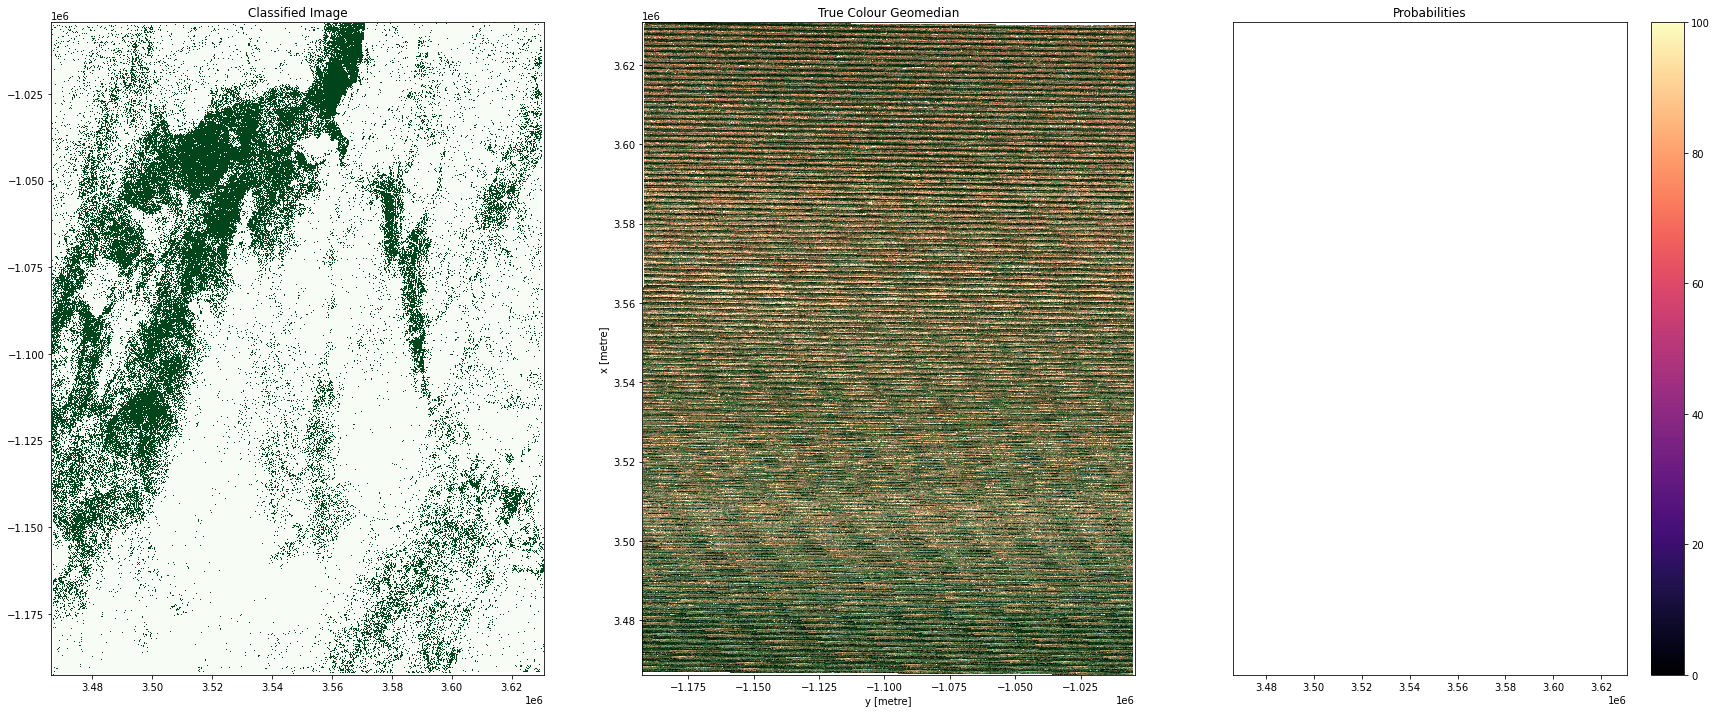

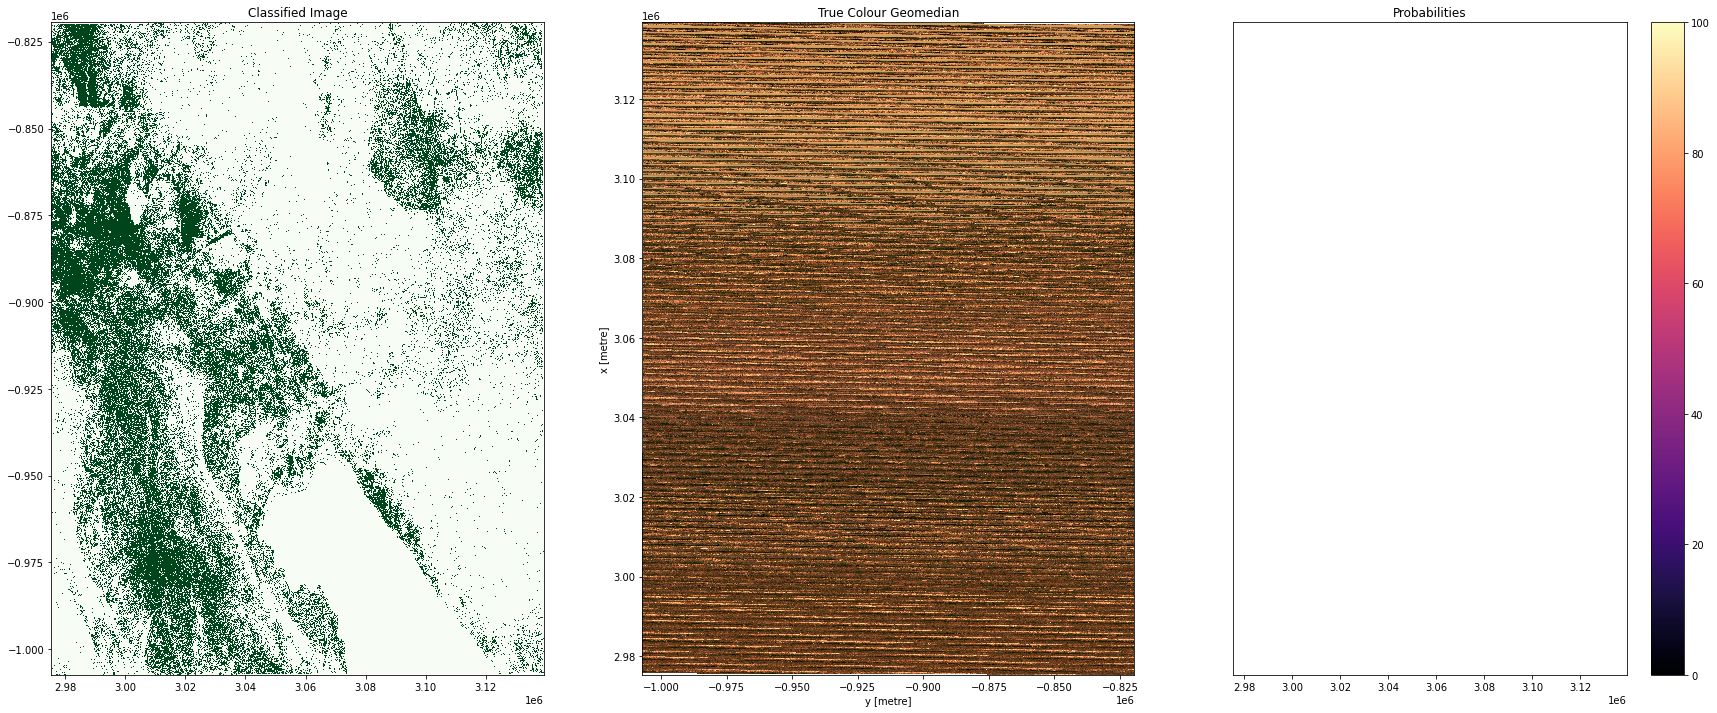

In [10]:
for i in range(0, 2):
    fig, axes = plt.subplots(1, 3, figsize=(30, 12))


    # Plot classified image
    predictions[i].Predictions.plot(ax=axes[0], 
                   cmap='Greens', 
                   add_labels=False, 
                   add_colorbar=False)

    # Plot true colour image
    rgb(predictions[i], bands=['red_S2','green_S2','blue_S2'],
        ax=axes[1], percentile_stretch=(0.01, 0.99))

    predictions[i].Probabilities.plot(ax=axes[2], 
                   cmap='magma',
                   vmin=0,
                   vmax=100,
                   add_labels=False, 
                   add_colorbar=True)

    # Remove axis on right plot
    axes[2].get_yaxis().set_visible(False)

    # Add plot titles
    axes[0].set_title('Classified Image')
    axes[1].set_title('True Colour Geomedian')
    axes[2].set_title('Probabilities');